<div class="alert alert-block alert-info">
    <b>Name:</b> Teresita Ramirez, <b>Date:</b> October 2022 , <b>Assignment-ASTRON441-0</b>
</div>

## <font color=darkblue>Loading Modules/Libraries</font>


In [1]:
import json
import math
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.font_manager
import numpy as np
import pandas as pd  
import glob
import requests
from lmfit.models import LinearModel
from matplotlib import rc,gridspec
from matplotlib.ticker import MultipleLocator
from pprint import pprint
from scipy.optimize import curve_fit
from astropy import units as u
from astropy import constants as const

## <font color=darkblue>Loading SNe 1a parameters from ZTF:</font>
#### Different SNe Type 1a data from the ZTF BTS Sample Explorer (https://sites.astro.caltech.edu/ztf/bts/bts.php)

In [2]:
data = pd.read_csv (r'real_SN_3_samples.csv')  
df = pd.DataFrame(data, columns= ['ZTFID','IAUID','RA','Dec','redshift','A_V'])
df

,ZTFID,IAUID,RA,Dec,redshift,A_V
0,ZTF22aajpgof,SN2022jsg,15:39:47.12,-20:09:52.7,0.07000,0.385
1,ZTF22aaijrul,SN2022jsn,21:35:51.21,+10:51:07.3,0.09000,0.165
2,ZTF22aahhlnd,SN2022ied,12:59:37.27,+05:36:52.7,0.05100,0.095
3,ZTF22aagsmli,SN2022imy,10:36:28.06,+44:52:58.2,0.07610,0.052
4,ZTF22aafqamd,SN2022hqu,08:23:56.74,+42:06:42.8,0.05900,0.127
5,ZTF22aafoweb,SN2022hox,15:03:27.71,+34:24:52.4,0.05707,0.040
6,ZTF22aajryew,SN2022jte,18:00:11.06,+48:39:16.4,0.05096,0.125
7,ZTF22aaejjtb,SN2022gqh,09:38:08.78,+11:07:49.2,0.06500,0.100
8,ZTF22aaedgbt,SN2022fqo,15:35:59.60,+03:25:39.2,0.08500,0.152
9,ZTF21acipdhn,SN2021abzk,10:30:12.32,+78:48:23.1,0.07900,0.069


## <font color=darkblue>Loading data and parsing JSON for $g_{band}$ Values</font>


In [3]:
list_of_MAGPSF=[]
list_of_MJD=[]
list_of_FID=[]
list_of_SIGMAPSF=[]

for i in df['ZTFID']:
    
    # open the json file
    json_file= open(str(i)+'.json')
    json_str = json_file.read()
    json_data = json.loads(json_str)

    # Using 'pprint' to print out the data with the proper indents
    #pprint(json_data) 

    #Looking only for green band params:
    MAGPSF=[]
    MJD=[]
    FID=[]
    SIGMAPSF=[]
    ObjectID=[]
    for parameter, v in json_data.items():
        DumpedData = json.dumps(v)
        DesiredValue = json.loads(DumpedData)
        if parameter == 'objectId':
            ZTF_ID= DumpedData
            ObjectID.append(ZTF_ID)
        if parameter == 'candidates':
            for i in DesiredValue:

                if 'sigmapsf' in i.keys():
                    if i['fid']==1:
                        mag_psf = i['magpsf']
                        MAGPSF.append(mag_psf)
                        mjd = i['mjd']
                        MJD.append(mjd)
                        fid = i['fid']
                        FID.append(fid)
                        sigma_psf = i['sigmapsf']
                        SIGMAPSF.append(sigma_psf)
    list_of_MAGPSF.append(np.array(MAGPSF))
    list_of_MJD.append(np.array(MJD))
    list_of_FID.append(np.array(FID))
    list_of_SIGMAPSF.append(np.array(SIGMAPSF))

In [4]:
MAGPSF = np.array(list_of_MAGPSF,dtype=object)
MJD = np.array(list_of_MJD,dtype=object)
FID = np.array(list_of_FID,dtype=object)
SIGMAPSF = np.array(list_of_SIGMAPSF,dtype=object)
redshift = df['redshift']
Reddening = df['A_V']
ZTF_ID = df['ZTFID']

## <font color=darkblue>Setting $T_{peak}=0$ and getting relative times to SN frame:</font>

In [5]:
list_relative_times=[]
for j in range(len(MJD)):
    find_peak_data=np.argmin(MAGPSF[j])
    rescaled_times=np.subtract(MJD[j],MJD[j][find_peak_data])
    relative_times=rescaled_times/(1+redshift[j])
    list_relative_times.append(relative_times)


## <font color=darkblue>Obtaining data $5 days < M_{peak} < 25 days$</font>

In [6]:
list_truncated_mag=[]
list_truncated_mjd=[]
list_truncated_sig=[]

for n in range(len(MAGPSF)):

    find_peak_data=np.argmin(MAGPSF[n])
    
    # 5 MJD before peak:
    start_JD=list_relative_times[n][find_peak_data]-5

    # 25 MJD after peak:
    end_JD=list_relative_times[n][find_peak_data]+25
    if df['ZTFID'][n] == 'ZTF20aatzwgk':
            start_JD=list_relative_times[n][find_peak_data]-3 #This sample doesnt have enough data points to account for 5 days before peak. 
    for i in range(len(list_relative_times[n])):
        if list_relative_times[n][i]<=start_JD:
            upperbound=i
            break

    for i in range(len(list_relative_times[n])):       
        if list_relative_times[n][i]<=end_JD:
            lowerbound=i
            break
    if df['ZTFID'][n] == 'ZTF20aatzwgk':
            upperbound=upperbound+1
            
    truncated_mag=MAGPSF[n][lowerbound:upperbound]
    truncated_mjd=list_relative_times[n][lowerbound:upperbound]
    truncated_sig=SIGMAPSF[n][lowerbound:upperbound]
    
    list_truncated_mag.append(truncated_mag)
    list_truncated_mjd.append(truncated_mjd)
    list_truncated_sig.append(truncated_sig)


## <font color=darkblue>Polynomial Fit Model using <code>np.polyfit</code> </font>


In [7]:
list_fitted_vals=[]
list_polyfits=[]
for i in range(len(list_relative_times)):
    poly_fit = np.polyfit(list_truncated_mjd[i], list_truncated_mag[i], deg=5, w=1/list_truncated_sig[i])
    fitted_vals=np.polyval(poly_fit, list_truncated_mjd[i])
    list_fitted_vals.append(fitted_vals)
    list_polyfits.append(poly_fit)

/Users/undercovermartian/opt/anaconda3/envs/ASTRON/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/undercovermartian/opt/anaconda3/envs/ASTRON/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


## <font color=darkblue>Plotting $g_{band}$ Light Curve</font>
#### All Light Curves in one plot:



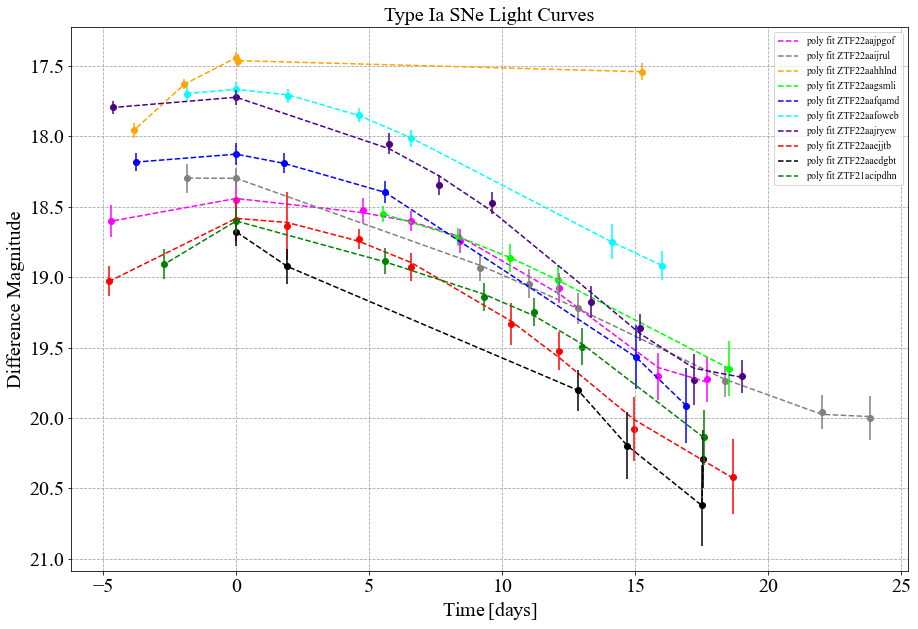

In [8]:
colors=['fuchsia','grey','orange','lime','blue','cyan','indigo','red','black','green']
fig = plt.figure(figsize = (15,10))

plt.grid(True,which="both", linestyle='--',color='0.65')
plt.rcParams["font.family"] = "Times New Roman"
plt.xticks(fontsize = "20",fontname='Times New Roman')
plt.yticks(fontsize = "20",fontname='Times New Roman')
for s in range(len(list_fitted_vals)):
    plt.scatter(list_truncated_mjd[s],list_truncated_mag[s],color=str(colors[s]))
    plt.errorbar(list_truncated_mjd[s], list_truncated_mag[s],list_truncated_sig[s],linestyle="None",color=str(colors[s]))#,color='red')
    plt.plot(list_truncated_mjd[s],list_fitted_vals[s],label='poly fit '+str(ZTF_ID[s]),linestyle='--',color=str(colors[s]))

plt.gca().invert_yaxis()
plt.xlabel('Time$\,$[days]',size = 20, fontname='Times New Roman')
plt.ylabel('Difference Magnitude',size = 20, fontname='Times New Roman')
plt.title('Type Ia SNe Light Curves',size = 20, fontname='Times New Roman')
ax = plt.gca()  # only to illustrate what `ax` is
plt.legend()
plt.show()